In [1]:
!pip install -q altair shap causal-learn graphviz pydot plotnine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 6.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout


from plotnine.data import mpg
from plotnine import ggplot, aes, geom_histogram, geom_density, theme_bw, labs
from IPython.display import display

import networkx as nx

import altair as alt

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz
from causallearn.graph.Edge import Endpoint

import shap
from shap import Explanation, KernelExplainer, summary_plot, force_plot

In [3]:
df = pd.read_csv('/content/gene_expression.csv')

In [4]:
df.head()

,Gene One,Gene Two,Cancer Present
0,4.3,3.9,1
1,2.5,6.3,0
2,5.7,3.9,1
3,6.1,6.2,0
4,7.4,3.4,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gene One        3000 non-null   float64
 1   Gene Two        3000 non-null   float64
 2   Cancer Present  3000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 70.4 KB


In [8]:
df.describe()

,Gene One,Gene Two,Cancer Present
count,3000.000000,3000.000000,3000.000000
mean,5.600133,5.410467,0.500000
std,1.828388,1.729081,0.500083
min,1.000000,1.000000,0.000000
25%,4.300000,4.000000,0.000000
50%,5.600000,5.400000,0.500000
75%,6.900000,6.700000,1.000000
max,10.000000,10.000000,1.000000


In [9]:
df['Cancer Present'].value_counts(normalize=True)

,proportion
Cancer Present,
1,0.5
0,0.5


In [10]:
plot_gene_one = (
    ggplot(df, aes(x='Gene One')) +
    geom_histogram(aes(y='..density..'), fill='skyblue', bins=30, alpha=0.7) +
    geom_density(color='darkblue', size=1.0) +
    labs(title='Distribution of Gene One Expression', x='Gene One Expression Level', y='Density') +
    theme_bw()
)

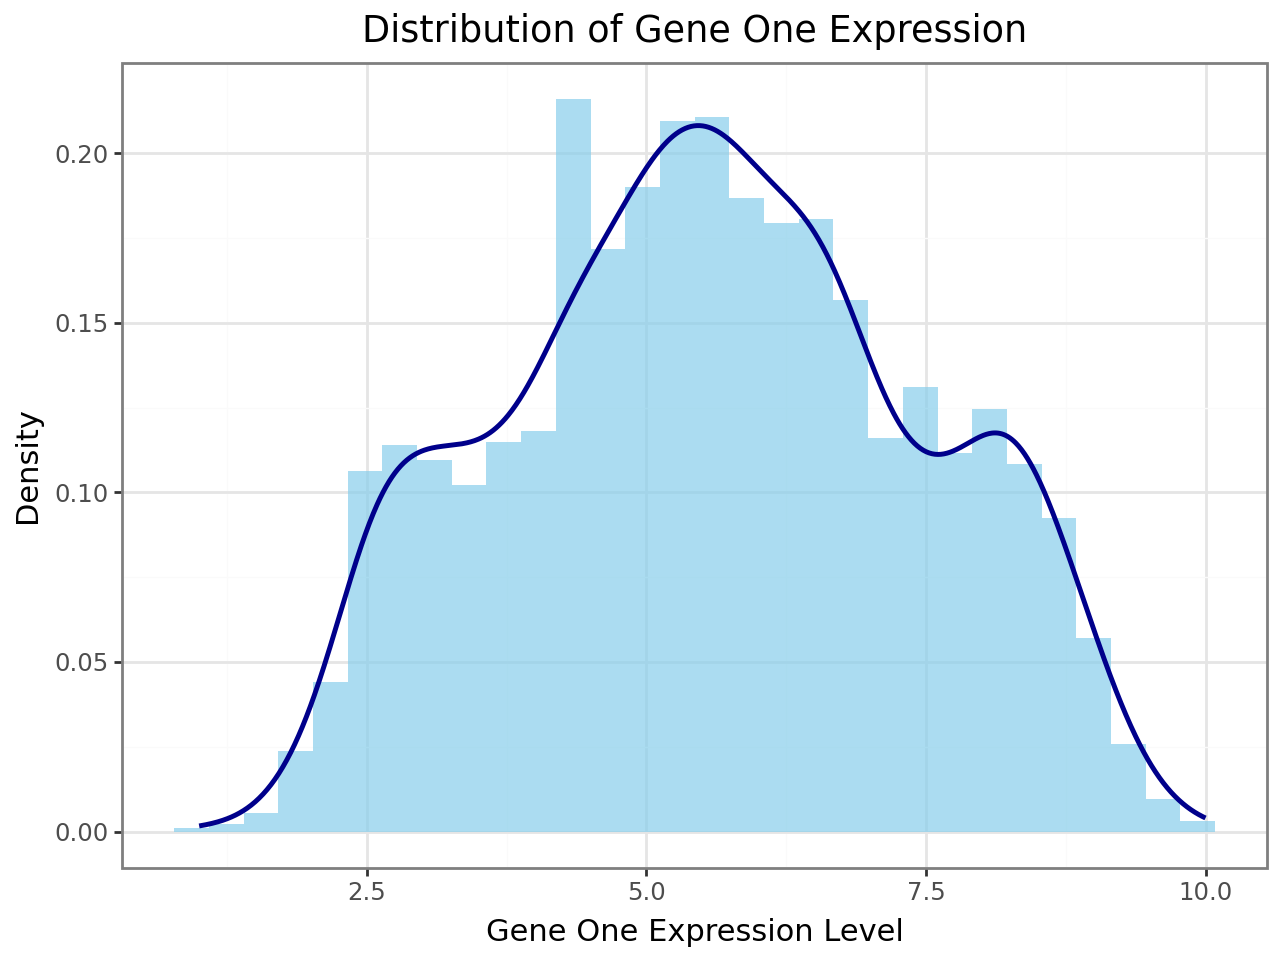

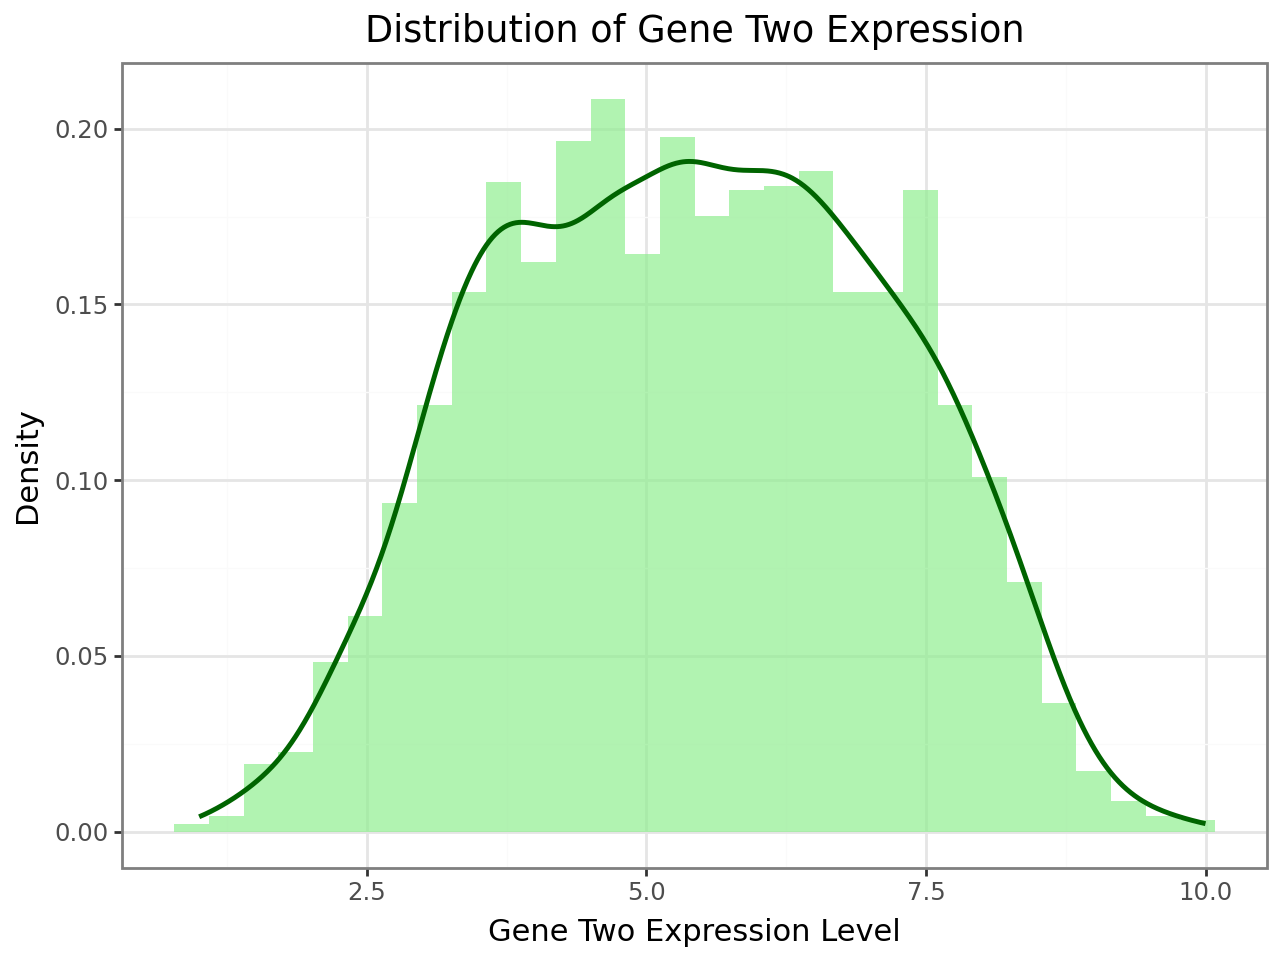

In [11]:
plot_gene_two = (
    ggplot(df, aes(x='Gene Two')) +
    geom_histogram(aes(y='..density..'), fill='lightgreen', bins=30, alpha=0.7) +
    geom_density(color='darkgreen', size=1.0) +
    labs(title='Distribution of Gene Two Expression', x='Gene Two Expression Level', y='Density') +
    theme_bw()
)

# Display plots
display(plot_gene_one, plot_gene_two)

Gene 1 is expressed consistently like a normal distribution. It may be constitutively expressed.

Gene 2 is expressed in a wider distribution meaning it varies differently in normal and disease states.

In [12]:
df_grouped = df.groupby('Cancer Present')[['Gene One', 'Gene Two']].mean().reset_index()

# Melt the DataFrame to long format
df_bar = df_grouped.melt(id_vars='Cancer Present',
                         var_name='Gene',
                         value_name='Expression')

In [13]:
df_bar.rename(columns={'Cancer Present': 'Cancer'}, inplace=True)

# Plot
bar_chart = alt.Chart(df_bar).mark_bar().encode(
    x=alt.X('Gene:N', title='Gene'),
    y=alt.Y('Expression:Q', title='Mean Expression'),
    color=alt.Color('Cancer:N', scale=alt.Scale(range=['#1f77b4', '#d62728'])),
    column=alt.Column('Cancer:N', title='Cancer Status'),
    tooltip=['Gene:N', 'Expression:Q', 'Cancer:N']
).properties(
    title="Mean Gene Expression by Cancer Status",
    width=150,
    height=300
)

bar_chart

alt.Chart(...)

In [14]:
scatter = alt.Chart(df).mark_circle(size=60).encode(
    x=alt.X('Gene One', title='Gene One Expression'),
    y=alt.Y('Gene Two', title='Gene Two Expression'),
    color=alt.Color('Cancer Present:N', scale=alt.Scale(range=['#1f77b4', '#d62728']), legend=alt.Legend(title='Cancer')),
    tooltip=['Gene One', 'Gene Two', 'Cancer Present']
).properties(
    width=500,
    height=400,
    title='Scatter Plot of Gene One vs Gene Two by Cancer Status'
).interactive()

scatter

alt.Chart(...)

In [15]:
scaler = StandardScaler()
X = scaler.fit_transform(df[['Gene One', 'Gene Two']])
y = df['Cancer Present']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42)

In [17]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# Predict on test set
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

# Evaluate model performance
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob))

Confusion Matrix:
 [[325  50]
 [ 42 333]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88       375
           1       0.87      0.89      0.88       375

    accuracy                           0.88       750
   macro avg       0.88      0.88      0.88       750
weighted avg       0.88      0.88      0.88       750


ROC AUC Score: 0.9485866666666666


In [18]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob_rf))

Confusion Matrix:
 [[341  34]
 [ 25 350]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92       375
           1       0.91      0.93      0.92       375

    accuracy                           0.92       750
   macro avg       0.92      0.92      0.92       750
weighted avg       0.92      0.92      0.92       750


ROC AUC Score: 0.9801386666666667


/tmp/ipython-input-19-1183823344.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



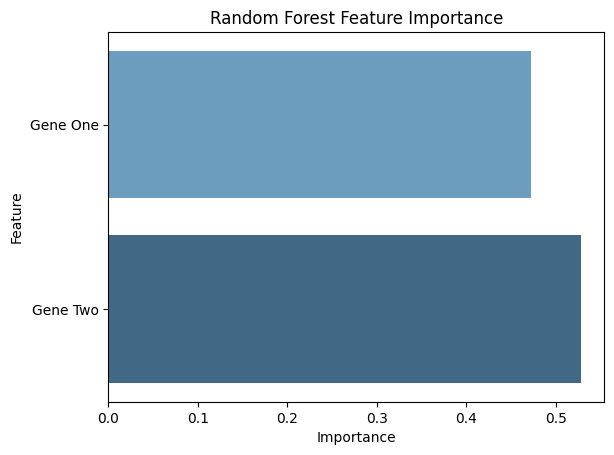

In [19]:
feat_df = pd.DataFrame({
    'Feature': ['Gene One', 'Gene Two'],
    'Importance': rf.feature_importances_
})

# Plotting
sns.barplot(data=feat_df, x='Importance', y='Feature', palette='Blues_d')
plt.title('Random Forest Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [20]:
tf.random.set_seed(42)

# Define model
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193 (772.00 B)

 Trainable params: 193 (772.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4681 - loss: 0.7219 - val_accuracy: 0.7156 - val_loss: 0.5741
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6618 - loss: 0.5892 - val_accuracy: 0.8533 - val_loss: 0.4934
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7215 - loss: 0.5367 - val_accuracy: 0.8644 - val_loss: 0.4346
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7719 - loss: 0.4875 - val_accuracy: 0.8644 - val_loss: 0.3850
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8112 - loss: 0.4384 - val_accuracy: 0.8667 - val_loss: 0.3492
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8088 - loss: 0.4400 - val_accuracy: 0.8711 - val_loss: 0.3303
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8293 - loss: 0.3940 - val_accuracy: 0.8711 - val_loss: 0.3186
Epoch 8/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8367 - loss: 0.4071 - val_accuracy: 0.8711 - v

In [22]:
# Predictions
y_pred_nn = (model.predict(X_test) > 0.5).astype("int32").flatten()
y_prob_nn = model.predict(X_test).flatten()

# Metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nn))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nn))
print("\nROC AUC Score:", roc_auc_score(y_test, y_prob_nn))

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Confusion Matrix:
 [[351  24]
 [ 21 354]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       375
           1       0.94      0.94      0.94       375

    accuracy                           0.94       750
   macro avg       0.94      0.94      0.94       750
weighted avg       0.94      0.94      0.94       750


ROC AUC Score: 0.9806079999999999


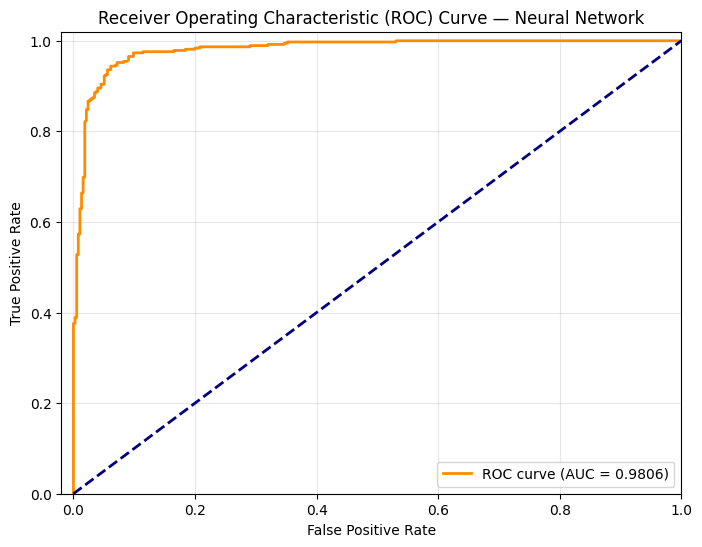

In [23]:
# Compute false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_prob_nn)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.02, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve — Neural Network')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

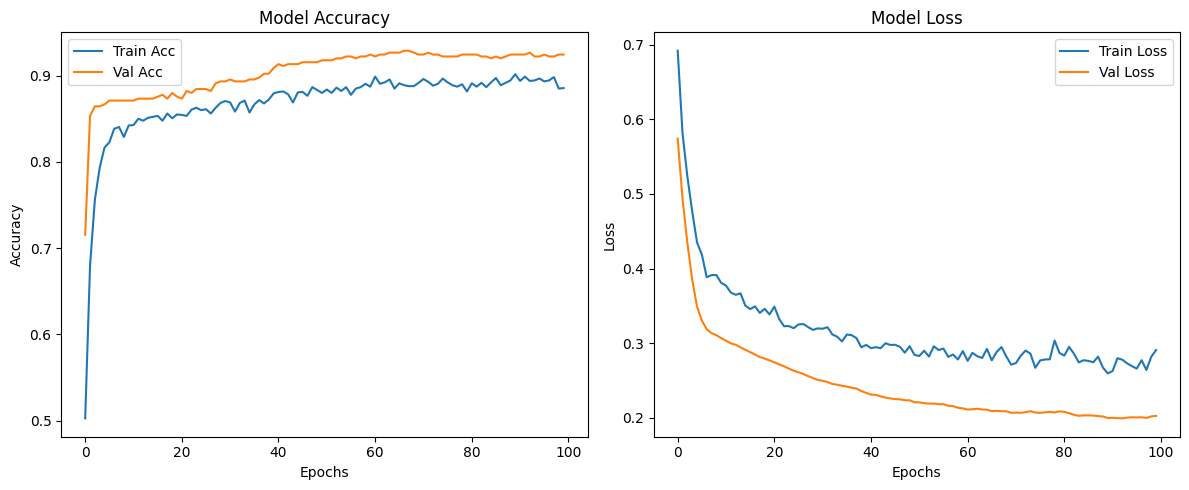

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

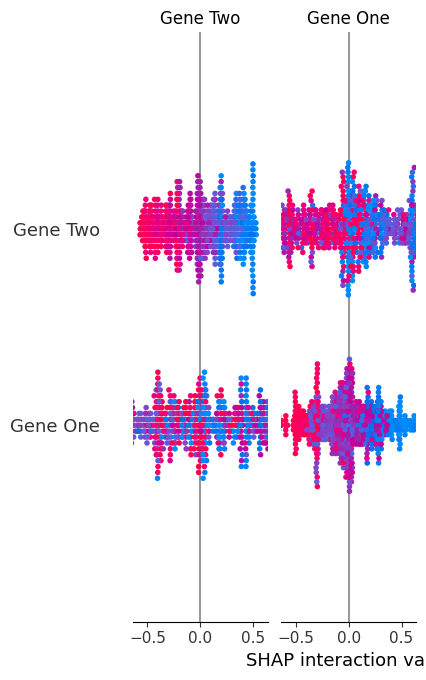

In [25]:
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test)


shap.summary_plot(shap_values_rf, features=X_test, feature_names=['Gene One', 'Gene Two'])

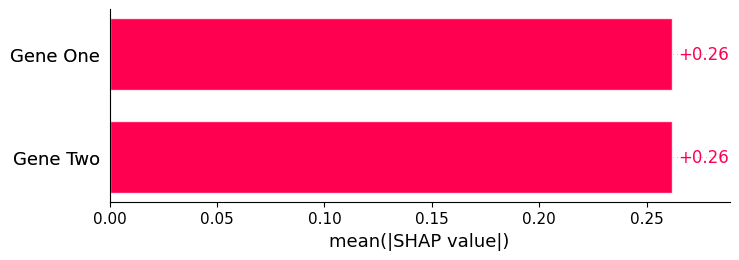

In [26]:
explanation = shap.Explanation(
    values=shap_values_rf[1],
    base_values=explainer_rf.expected_value[1],
    data=X_test,
    feature_names=['Gene One', 'Gene Two']
)

# Display the chart
shap.plots.bar(explanation)

This bar chart ranks features by their average absolute impact on predictions, providing a clear view of global importance across all predictions.

In [27]:
# Subset for KernelExplainer
X_sample = X_test[:100]

# Background dataset for SHAP
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# Create KernelExplainer
explainer_nn = shap.KernelExplainer(model.predict, background)
shap_values_nn = explainer_nn.shap_values(X_sample, nsamples=100)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━

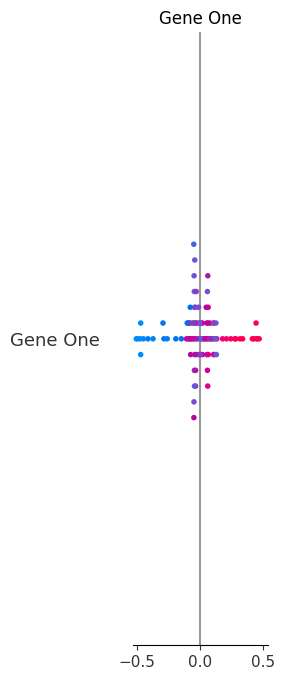

In [30]:
# For binary classification, KernelExplainer returns one array:
shap.summary_plot(shap_values_nn, features=X_sample, feature_names=['Gene One', 'Gene Two'])

In [31]:
# Compute correlation matrix
gene_corr = df[['Gene One', 'Gene Two']].corr()

# Initialized the graph
G = nx.Graph()

# Add nodes
for gene in gene_corr.columns:
    G.add_node(gene)

# Add edges for correlations above a threshold
threshold = 0.2
for i in gene_corr.columns:
    for j in gene_corr.columns:
        if i != j and abs(gene_corr.loc[i, j]) > threshold:
            G.add_edge(i, j, weight=gene_corr.loc[i, j])

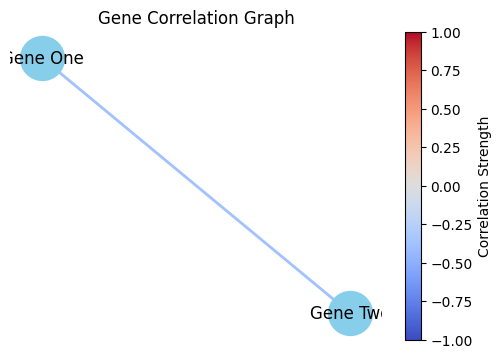

In [32]:
# Generate positions
pos = nx.spring_layout(G, seed=42)

# Plot nodes
plt.figure(figsize=(6, 4))
nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1000)

# Add labels to nodes
nx.draw_networkx_labels(G, pos, font_size=12)

# Plot edges with colors
edges = nx.draw_networkx_edges(
    G, pos, width=2,
    edge_color=[G[u][v]['weight'] for u, v in G.edges()],
    edge_cmap=plt.cm.coolwarm,
    edge_vmin=-1, edge_vmax=1
)

# Add colorbar
plt.colorbar(edges, label='Correlation Strength')

plt.title("Gene Correlation Graph")
plt.axis('off')
plt.show()

Gene One and Gene Two are negatively correlated, meaning as the expression of one increases, the expression of the other tends to decrease.

The correlation is not extremely strong (not dark blue), but it is still meaningfully negative.

Future Work

To expand causal modeling:

Use Bayesian Networks for probabilistic causal inference.

Introduce counterfactual analysis.

Integrate do-calculus for intervention simulation.

Combine causal graphs with SHAP to build counterfactual explanations.